In [176]:
import sys,os
os.environ['pRT_input_data_path'] = '/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/input_data/'
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

from petitRADTRANS import Radtrans
from petitRADTRANS.retrieval.util import *
from petitRADTRANS.retrieval.chemistry import get_abundances
from petitRADTRANS.retrieval.models import  emission_model_diseq,\
                                            emission_model_diseq_simple_patchy_clouds,\
                                            interpolated_profile_emission,\
                                            guillot_emission,\
                                            gradient_profile_emission
import petitRADTRANS.retrieval.plot_style as ps
from glob import glob
import scicomap as sc
matplotlib.rcParams['axes.linewidth'] = 2
import json
from molmass import Formula

version = "v01"
map_538 = sc.ScicoQualitative(cmap='538')
fixed_cmap_538 = map_538.get_mpl_color_map()
colour_dict = {"b":fixed_cmap_538(3/6),
              "c":fixed_cmap_538(2/6),
              "d":fixed_cmap_538(1/6),
              "e":fixed_cmap_538(0/6)}

model_function_dictionary = {}
model_function_dictionary["emission_model_diseq"] = emission_model_diseq
model_function_dictionary["emission_model_diseq_simple_patchy_clouds"] = emission_model_diseq_simple_patchy_clouds
model_function_dictionary["interpolated_profile_emission"] = interpolated_profile_emission
model_function_dictionary["guillot_emission"] = guillot_emission
model_function_dictionary["gradient_profile_emission"] = gradient_profile_emission
              

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [177]:
def c_to_o_from_abundances(samples):
    co = 10**samples["CO_all_iso_HITEMP"]
    h2o = 10**samples["H2O_Exomol"]
    h2 = 0.73 * (1.0-(co + h2o))
    he = 0.24 * (1.0-(co + h2o))
    abunds = {"CO_all_iso": co, "H2O": h2o, "H2": h2, "He":he}
    nfracs = mass_to_number(abunds)
    freeco = nfracs["CO_all_iso"]/(nfracs["CO_all_iso"]+ nfracs["H2O"])
    samples["C/O"] = freeco
    return 

def calculate_gravity_params(samples):
    gravity = -np.inf
    R_pl = -np.inf
    if 'log_g' in samples.columns and 'mass' in samples.columns:
        gravity = 10**samples['log_g']
        R_pl = np.sqrt(nc.G*samples['mass']/gravity)
        samples["R_pl"] = R_pl
    elif 'log_g' in samples.columns:
        gravity= 10**samples['log_g']
        R_pl = samples['R_pl']
        samples["mass"] = gravity *R_pl**2 / nc.G
    elif 'mass' in samples.columns:
        R_pl = samples['R_pl']
        gravity = nc.G * samples['mass']/R_pl**2
        samples["log_g"] = np.log10(gravity)
    else:
        print("Pick two of log_g, R_pl and mass!")
    return

def calc_feh_from_abundances(samples, line_species):
    solar_nfracs = {}
    solar_nfracs['H'] = 0.9207539305712663
    solar_nfracs['He'] = 0.07836886940606574
    solar_nfracs['C'] = 0.0002478241000191816
    solar_nfracs['N'] = 6.225060569980629e-05
    solar_nfracs['O'] = 0.00045096580003490476
    solar_nfracs['Na'] = 1.6000869436558967e-06
    solar_nfracs['Mg'] = 3.665587420837336e-05
    solar_nfracs['Al'] = 2.5950000002008533e-06
    solar_nfracs['Si'] = 2.979500000230613e-05
    solar_nfracs['P'] = 2.3667020201598627e-07
    solar_nfracs['S'] = 1.2137900735543473e-05
    solar_nfracs['Cl'] = 2.911679585221254e-07
    solar_nfracs['K'] = 9.866056120020401e-08
    solar_nfracs['Ca'] = 2.0143901144484638e-06
    solar_nfracs['Ti'] = 8.206228044298752e-08
    solar_nfracs['V'] = 7.836886941506495e-09
    solar_nfracs['Fe'] = 2.911679585221254e-05
    solar_nfracs['Ni'] = 1.5280711681810828e-06


    """solar_mass_fracs = {}
    norm = 0.
    for species in solar_nfracs.keys():
        mass = Formula(species).mass
        solar_mass_fracs[species] = solar_nfracs[species]*mass
        norm += solar_nfracs[species]*mass

    for species in solar_nfracs.keys():
        solar_mass_fracs[species] = solar_mass_fracs[species]/norm"""

    mass_fractions = {}
    msum = 0
    for spec in line_species:
        mass_fractions[spec] = 10**samples[spec].to_numpy().flatten()
        msum += 10**samples[spec].to_numpy().flatten()
       
    if "H2" in samples.columns:
        mass_fractions["H2"] = 10**samples["H2"].to_numpy()
    else:
        mass_fractions["H2"] = 0.766 * (1.0-msum)
    if "He" in samples.columns:
        mass_fractions["He"] = 10**samples["He"].to_numpy()
    else:
        mass_fractions["He"] = 0.234 * (1.0-msum)
    n_fracs = mass_to_number(mass_fractions)

    atom_abunds = solar_nfracs['C'] + solar_nfracs['O']
    CNO_metals = n_fracs['H2O_Exomol']

    if 'CH4' in samples.columns:
        CNO_metals = CNO_metals + n_fracs['CH4'] 

    if 'NH3' in samples.columns:
        CNO_metals = CNO_metals +  n_fracs['NH3']
        atom_abunds = atom_abunds + solar_nfracs['N']

    if 'CO_all_iso_HITEMP' in samples.columns:
        CNO_metals = CNO_metals + n_fracs['CO_all_iso_HITEMP']

    if 'CO2' in samples.columns:
        CNO_metals = CNO_metals + (3* n_fracs['CO2'])

    if 'SO2' in samples.columns:
        CNO_metals = CNO_metals + (3* n_fracs['SO2'])
        atom_abunds = atom_abunds + solar_nfracs['S']

    metallicity = np.log10(CNO_metals/atom_abunds) 
    samples["Fe/H"] = metallicity
    return metallicity

def get_abundances_and_pbases(pRT_Object, samples, model_generating_function, name = ""):
    abundance_profiles = {} #Full mass fraction vertical profiles (nsample, nspecies, npressure)
    Pbases_all = {} # Cloud base pressures (nsample, ncloudspecies)
    Pbase_abundances = {} # Abundance at PBase (nsample, ncloudspecies)
    radius_profiles = {} #Full particle size profiles (nsample, ncloudspecies, npressure)
    Pbase_radius = {} # Particle radius at bottom of cloud (nsample, ncloudspecies)
    
    pressures = pRT_object.press/1e6
    for cloud in pRT_Object.cloud_species:
        Pbases_all[cloud] = []
        Pbase_abundances[cloud] = []
    for line in pRT_Object.line_species:
        abundance_profiles[line] = []
    for row in samples.iterrows():
        params = {}
        for key in samples.columns:
            params[key] = row[key]
        pressure, temperatures = model_generating_function(pRT_Object,
                                                    params,
                                                    AMR = False,
                                                    PT_plot_mode = True)
        abundances, MMW, small_index, Pbases = get_abundances(pressure,
                                                             temperatures,
                                                             pRT_Object.line_species,
                                                             pRT_Object.cloud_species,
                                                             params,
                                                             AMR =False)
        for key,val in abundances.items():
            abundance_profiles[key].append(val)
        for key,val in Pbases.items():
            Pbases_all[key].append(val)
            Pbase_abundances[key].append(abundances[key][np.argmin(np.abs(pressures-val))])
        for i,cname in enumerate(pRT_Object.cloud_species):
            radius_profiles[cname].append(pRT_Object.r_g[i])
            Pbase_radius[cname].append(pRT_Object.r_g[i][np.argmin(np.abs(pressures-row[f"PBase_{cname}"]))])
    np.savez(f"retrieval_output_arrays/{name}_particle_radii",radius_profiles)
    for key, val in Pbase_radius.items():
        samples[f"Pbase_radius_{key}"] = val
    np.savez(f"retrieval_output_arrays/{name}_abundance_profiles",abundance_profiles)
    for key, val in Pbases_all.items():
        samples[f"log_Pbase_{key}"] = np.log10(val)
        samples[f"Pbase_{key}"] = val
        if f"eq_scaling_{key}" in samples.columns:
            sample[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])

def pbase_from_log(sample):
    for key in sample.columns:
        if "Pbase" in key and "log" in key:
            cloud = key.split('_')[-1]
            sample[f"Pbase_{cloud}"] = 10**sample[key]
            
def sample_teff(pRT_Object, samples, model_generating_function, distance = 10.0*nc.pc, name = ""):
    r"""
    This function samples the outputs of a retrieval and computes Teff
    for each sample. For each sample, a model is computed at low resolution,
    and integrated to find the total radiant emittance, which is converted into
    a temperature using the stefan boltzmann law: $j^{\star} = \sigma T^{4}$.
    Teff itself is computed using util.calc_teff.

    Args:
        sample_dict : dict
            A dictionary, where each key is the name of a retrieval, and the values
            are the equal weighted samples.
        param_dict : dict
            A dictionary where each key is the name of a retrieval, and the values
            are the names of the free parameters associated with that retrieval.
        ret_names : Optional(list(string))
            A list of retrieval names, each should be included in the sample_dict.
            If left as none, it defaults to only using the current retrieval name.
        nsample : Optional(int)
            The number of times to compute Teff. If left empty, uses the "take_PTs_from"
            plot_kwarg. Recommended to use ~300 samples, probably more than is set in
            the kwarg!
        resolution : int
            The spectra resolution to compute the models at. Typically, this should be very
            low in order to enable rapid calculation.
    Returns:
        tdict : dict
            A dictionary with retrieval names for keys, and the values are the calculated
            values of Teff for each sample.
    """
    teffs = []
    #rands = np.random.randint(0, samples.shape[0], nsample)
    for row in samples.iterrows():
        params = {}
        for key in samples.columns:
            params[key] = row[key]
        wlen, model = model_generating_function(pRT_Object,
                                                params,
                                                False,
                                                False)

        tfit = teff_calc(wlen, model, distance, params["R_pl"])
        teffs.append(tfit)
    teffs = np.array(teffs)
    samples["Teff"] = teffs
    np.save(f"retrieval_output_arrays/{name}_sampled_teff", np.array(teffs))

def calc_lbol(sample):
    teff_index = np.argwhere(np.array(all_params) == "teff")[0]
    radius_index = np.argwhere(np.array(all_params) == "radius")[0]
    lum_planet = (
        4.0
        * np.pi
        * (sample["R_pl"]) ** 2.0
        * nc.sigma
        * samples["Teff"] ** 4.0
        / nc.l_sun
    )
    sample["Lbol"] = lum_planet

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [178]:
data_dir = "/Users/nasedkin/Documents/RetrievalResults/HR8799_2023_Retrievals/"
model_generating_function = emission_model_diseq
planets = ["b","c","d","e"]

samples = {}
max_evidence = {}
names = []

calc_teff = False
resolution = 40
line_species = ['H2O_Exomol', 
                'CO_all_iso_HITEMP', 
                'CH4', 
                'CO2', 
                'NH3', 
                'HCN',
                'H2S', 
                'FeH',
                'PH3', 
                'Na_allard', 
                'K_allard', 
                'TiO_all_Exomol', 
                'VO',
                'SiO']
for count,planet in enumerate(planets):
    full_list = sorted(glob(f"{data_dir}{planet}_full/out_PMN/*post_equal_weights*"))
    free_list = sorted(glob(f"{data_dir}{planet}_free/out_PMN/*post_equal_weights*"))
    max_evidence[planet] = 0.0
    for f in full_list:
        short = f.split("_post_equal_weights")[0]
        name = short.split("/")[-1]
        pars = json.load(open(short+'_params.json'))
        pars.append("log_likelihood")
        sample = pd.read_csv(f, delim_whitespace=True,names=pars)
        if sample.shape[0] < 100:
            print("Need more than 100 sample in post equal weights!")
            continue
        names.append(name)
        # Setup the pRT object
        resolution = 40
        

        continuum_opacities = ['H2-H2', 'H2-He']  
        rayleigh_species = ['H2', 'He']  

        species = []
        for spec in line_species:
            species.append(spec + "_R_" + str(resolution))
        
        summary_filename = f"{data_dir}{planet}_full/{name}_ret_summary.txt" 
        if os.path.exists(summary_filename):
            with open(summary_filename) as sumfile:
                for s in sumfile:
                    if "log Z" in s:
                        evidence = float(s.split("=")[-1].split("+")[0].strip())
                        if evidence > max_evidence[planet]:
                            max_evidence[planet] = evidence
                        sample.log10_baysian_evidence = evidence
                    if "𝛘^2/DoF" in s:
                        chi2 = float(s.split("=")[-1].split("+")[0].strip())
                        sample.chi2_DoF = chi2

        if calc_teff:
            if os.path.exists(f"retrieval_output_arrays/{name}_sampled_teff.npy"):
                teff = np.load(f"retrieval_output_arrays/{name}_sampled_teff.npy")
                sample["Teff"] = teff
            else:
                summary_filename = f"{data_dir}{planet}_full/{name}_ret_summary.txt" 
                with open(summary_filename) as sumfile:
                   for s in sumfile:
                       if "Model Function" in s:
                           model_generating_function = model_function_dictionary[s.split("=").strip()]
                           break
                        
                cloud_species = []
                for key in sample.columns:
                    if "(c)" in key:
                        cname = key.split('_')[-1] + "_cd"
                        if not cname in cloud_species:
                            cloud_species.append(cname)
                            
                pressures = np.logspace(-6,3,100)
                prt_object = Radtrans(line_species=cp.copy(species),
                                        rayleigh_species=cp.copy(rayleigh_species),
                                        continuum_opacities=cp.copy(continuum_opacities),
                                        cloud_species=cp.copy(cloud_species),
                                        mode='c-k',
                                        wlen_bords_micron=[0.5, 28],
                                        do_scat_emis=True)
                sample_teff(prt_object, sample, model_generating_function, distance = 10.0*nc.pc, name = name)
                calc_lbol(sample)
                get_abundances_and_pbases(prt_object, sample, model_generating_function, name = name)
        calculate_gravity_params(sample)
        samples[name] = sample
    for f in free_list:
        short = f.split("_post_equal_weights")[0]
        name = short.split("/")[-1]
        pars = json.load(open(short+'_params.json'))
        pars.append("log_likelihood")

        sample = pd.read_csv(f, delim_whitespace=True,names=pars)
        if sample.shape[0] < 100:
            print("Need more than 100 sample in post equal weights!")
            continue
        if planet =="b" and not "correctos" in name:
            continue
        c_to_o_from_abundances(sample)
        calculate_gravity_params(sample)
        pbase_from_log(sample)
        atmo_species = []
        for key in sample.columns:
            if key in line_species:
                atmo_species.append(key)  

        if os.path.exists(summary_filename):
            with open(summary_filename) as sumfile:
                for s in sumfile:
                    if "log Z" in s:
                        evidence = float(s.split("=")[-1].split("+")[0].strip())
                        if evidence > max_evidence[planet]:
                            max_evidence[planet] = evidence
                        sample.log10_baysian_evidence = evidence
                    if "𝛘^2/DoF" in s:
                        chi2 = float(s.split("=")[-1].split("+")[0].strip())
                        sample.chi2_DoF = chi2
                          
        if calc_teff:
            if os.path.exists(f"retrieval_output_arrays/{name}_sampled_teff.npy"):
                teff = np.load(f"retrieval_output_arrays/{name}_sampled_teff.npy")
                sample["Teff"] = teff
            else:
                summary_filename = f"{data_dir}{planet}_full/{name}_ret_summary.txt" 
                with open(summary_filename) as sumfile:
                   for s in sumfile:
                       if "Model Function" in s:
                           model_generating_function = model_function_dictionary[s.split("=").strip()]
                           break
                       
                cloud_species = []
                species = []
                for key in sample.columns:
                    if "(c)" in key:
                        cname = key.split('_')[-1] + "_cd"
                        if not cname in cloud_species:
                            cloud_species.append(cname)
                    if key in line_species:
                        species.append(species + "_R_" + str(resolution))
                pressures = np.logspace(-6,3,100)
                prt_object = Radtrans(line_species=cp.copy(species),
                                        rayleigh_species=cp.copy(rayleigh_species),
                                        continuum_opacities=cp.copy(continuum_opacities),
                                        cloud_species=cp.copy(cloud_species),
                                        mode='c-k',
                                        wlen_bords_micron=[0.5, 28],
                                        do_scat_emis=True)
                sample_teff(prt_object, sample, distance = 10.0*nc.pc, name = name)
                calc_lbol(sample)
        calc_feh_from_abundances(sample, atmo_species)

        names.append(name)
        samples[name] = sample
     


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Need more than 100 sample in post equal weights!
Need more than 100 sample in post equal weights!
Need more than 100 sample in post equal weights!
Need more than 100 sample in post equal weights!
Need more than 100 sample in post equal weights!
Need more than 100 sample in post equal weights!
Need more than 100 sample in post equal weights!
Need more than 100 sample in post equal weights!


In [173]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def make_violin_plot(sample_dict, 
                     retrieval_list, 
                     parameter, 
                     facecolour = 'tab:blue', 
                     labels = None, 
                     xlabel = None, 
                     planet = "",
                     tag = "",
                     normalize = 1,
                     vline = None):
    fig, ax = plt.subplots(figsize = (4,16))
    data = []
    label_dict = {}
    label_dict["C/O"] = "C/O"
    label_dict["Fe/H"] = "[Z/H]"
    label_dict["H2O_Exomol"] = "Water Mass Fraction"
    label_dict["CO_all_iso_HITEMP"] = "CO Mass Fraction"
    label_dict["CH4"] = "CH4"
    label_dict["log_g"] = r"$\log g$ [cgs]"
    label_dict["R_pl"] = r"Radius [R$_{\rm Jup}$]"
    label_dict["mass"] = r"Mass [M$_{\rm Jup}$]"
    label_dict["Teff"] = r"T$_{\rm Eff}$ [K}]"

    param_borders = {}
    param_borders["Fe/H"] = (-0.55,2.55)
    param_borders["C/O"] = (-0.1,1.1)
    param_borders["R_pl"] = (0.55,1.5)
    param_borders["log_g"] = (2,6)

    if planet != "":
        facecolour=colour_dict[planet], 

    labels_use = []
    for i,name in enumerate(retrieval_list):
        if name in sample_dict.keys():
            if parameter in sample_dict[name].columns:
                data.append(sample_dict[name][parameter].to_numpy()/normalize)
                if labels is not None:
                    labels_use.append(labels[i])
                else:
                    labels_use.append(name)
        else:
            continue

    if len(data) == 0:
        print("No data to plot! Did you input a valid parameter? {parameter}")
        return
    parts = ax.violinplot(data, 
                          points = 1000,
                          showmedians=False,
                          vert=False,
                          widths = 0.8,
                          showextrema=False)
                          #positions = posns)

    colouruse_low = (facecolour[0][0],facecolour[0][1],facecolour[0][2],0.7)
    colouruse_high = (facecolour[0][0],facecolour[0][1],facecolour[0][2],1.0)
    for pc in parts['bodies']:
        pc.set_facecolor(colouruse_low)
        pc.set_edgecolor(colouruse_high)
        pc.set_linewidth(3)
        pc.set_alpha(0.9)
    #parts['cmedians'].set_color(facecolour)
    #parts['cquantiles'].set_color('w')

    quantile1, medians, quantile3 = [],[],[]
    for d in data:
        q1, m, q3 = np.quantile(d, [0.159, 0.50, 0.841])
        quantile1.append(q1)
        medians.append(m)
        quantile3.append(q3)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quantile1, quantile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    inds = np.arange(1, len(medians) + 1)
    ax.hlines(inds, quantile1, quantile3, color='w', linestyle='-', lw=3)
    ax.scatter(medians,inds,marker = 'o', color = facecolour, edgecolors='w',linewidths=2,s=24,zorder = 50)

    if vline is not None:
        ax.axvline(vline,-1,inds[-1]+3, color = 'darkgray',linestyle = '--', linewidth = 4,zorder = 0)
        ax.set_ylim(0,inds[-1]+1)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    elif parameter in label_dict.keys():
        ax.set_xlabel(label_dict[parameter])
    else:
        ax.set_xlabel(parameter)
    if parameter in param_borders.keys():
        ax.set_xlim(param_borders[parameter])
        
    ax.yaxis.tick_right()    
    ax.tick_params(axis="y",direction="in", pad = -75)
    ax.set_yticks(inds+0.3)
    ax.set_yticklabels(labels_use,  fontsize = 12)
    #ax.set_xlabel("Varying Models + Data Inclusion")
    plt.savefig(f"plots/HR8799{planet}_{parameter.replace('/','_')}_violinplot_{tag}_{version}.pdf",bbox_inches='tight')

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [179]:
short_names_b =    ["Clear",
                    "Fe Cloud (eq)",
                    "MgSiO3 Cloud (eq)",
                    "Fe + MgSiO3 Clouds (eq)",
                    "Fe + MgSiO3 Cloud (eq), Mass Prior",
                    "Fe + MgSiO3 Cloud (eq), Mass Prior, New phot",
                    "Fe + MgSiO3 Cloud (eq), Mass Prior, New phot, Broad Fe/H",
                    "Fe + MgSiO3 Cloud (free), Mass Prior, New phot, Broad Fe/H",
                    "Na2S Cloud (eq), Mass Prior, New phot",
                    "Free, Clear, 2 Nodes",
                    "Free, Clear, 3 Nodes",
                    "Free, Clear, 4 Nodes",
                    "Free, Clear, 5 Nodes",
                    "Free, Clear, 6 Nodes",
                    "Free, Clear, 7 Nodes",
                    "Free, Clear, 8 Nodes",
                    "Free, Clear, 9 Nodes",
                    "Free, MgSiO3 Cloud (free), 2 Nodes",
                    "Free, MgSiO3 Cloud (free), 3 Nodes",
                    "Free, MgSiO3 Cloud (free), 4 Nodes",
                    "Free, MgSiO3 Cloud (free), 5 Nodes",
                    "Free, MgSiO3 Cloud (free)"
               ]
retrievals_b = ['HR8799b_23_v02_diseq_all_scaleos_clear', 
              'HR8799b_23_v02_diseq_all_scaleos_eqFeCloud', 
              'HR8799b_23_v02_diseq_all_scaleos_eqMgCloud', 
              'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud', 
              'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud_mrprior', 
              'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot',
              'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_fseds', #Not Converging
              'HR8799b_23_v02_diseq_all_scaleos_eqNa2SCloud_mrprior_newdata_newphot', 
              'HR8799b_23_v02_diseq_all_scaleos_freeFeMgCloud_mrprior_newdata_newphot', 
              'HR8799b_23_v01_free_all_correctos_clear_0nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_1nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_2nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_3nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_4nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_5nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_6nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_7nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v4',
              'HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v4',
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_2nodes_v4', 
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_3nodes_v4',
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot_newphot_mrprior',  #Not converging.
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot' ]

retrievals_c = [#'HR8799c_23_v01_diseq_onlygrav_noos_clear', # bad logg
                'HR8799c_23_v01_diseq_onlygravphot_noos_clear_logg', 
                #'HR8799c_23_v01_diseq_onlygravphot_noos_clear',# bad logg
                'HR8799c_23_v01_diseq_onlygrav_noos_clear_logg', 
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqFeCloud', # bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqFeCloud', # bad logg
                'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud_logg',
                'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_logg', 
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud',# bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud', # bad logg
                'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_mrprior',
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqFeMgCloud', # bad logg
                'HR8799c_23_v01_diseq_all_grav_eqFeMgCloud_logg_fseds_newbins_newphot', 
                'HR8799c_23_v01_diseq_all_noos_eqFeMgCloud_logg', 
                #'HR8799c_23_v01_diseq_nogpi_noos_eqFeMgCloud',# bad logg
                'HR8799c_23_v01_diseq_all_noos_patchyeqFeMgCloud_logg_newbins_newphot', 
                'HR8799c_23_v01_diseq_all_osbin_patchyeqFeMgCloud_logg_newbins_newphot', 
                'HR8799c_23_v03_free_all_onlygrav_nogpi_clear_guillot', 
                'HR8799c_23_v03_free_all_onlygrav_withphot_nogpi_clear_guillot',
                'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygrav_nogpi_eqMgCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygrav_nogpi_freeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_all_noos_freeFeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_all_noos_freeMgCloud_guillot', 
                'HR8799c_23_v03_free_nograv_os_freeFeMgCloud_guillot_newphot' # Didn't converge after 40M, PEW 6Mb
                ]

retrievals_d = [#'HR8799d_23_v01_diseq_onlygrav_clear', 
                'HR8799d_23_v01_diseq_onlygravphot_eqFeCloud', 
                'HR8799d_23_v01_diseq_onlygravphot_eqMgCloud', 
                'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud_mrprior', 
                'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud', 
                'HR8799d_23_v01_diseq_all_eqFeMgCloud_fseds_newconv_newphot',
                'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI', 
                'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_spline',
                #'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_grad',
                'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_patchy',
                'HR8799d_23_v01_diseq_all_noales_eqFeMgCloud_newconv', 
                'HR8799d_23_v01_diseq_all_nocharis_eqFeMgCloud_newconv_newphot', 
                'HR8799d_23_v01_diseq_all_nogpi_eqFeMgCloud_newconv', 
                'HR8799d_23_v01_diseq_all_nograv_eqFeMgCloud_newconv', 
                'HR8799d_23_v01_diseq_all_nosph_eqFeMgCloud', 
                'HR8799d_23_v01_diseq_all_nosphfull_eqFeMgCloud', 
                'HR8799d_23_v01_diseq_all_shortsph_eqFeMgCloud', 
                #'HR8799d_23_v03_free_onlygrav_clear_guillot', 
                'HR8799d_23_v03_free_onlygravphot_clear_guillot', 
                'HR8799d_23_v03_free_onlygravphot_clear_free_MgCloud_guillot', 
                'HR8799d_23_v04_free_onlygravphot_free_MgCloud_guillot',
                'HR8799d_23_v04_free_all_freeFeMgCloud_guillot', 
                'HR8799d_23_v04_free_all_eqFeMgCloud_guillot_fseds' ,
                #'HR8799d_23_v04_free_all_freeMgFeCloud_spline_scaleALES_newSPHGPI'
                ]

retrievals_e = ['HR8799e_23_v01_diseq_onlygrav_clear',
                'HR8799e_23_v01_diseq_onlygravphot_clear', 
                'HR8799e_23_v01_diseq_onlygrav_eqMgCloud', 
                'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud',
                'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud_mrprior',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_mrprior', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds_newphot', 
                'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_logg',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_newphot_newSPH_fseds_mrprior', 
                'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad',
                'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds',
                'HR8799e_23_v02_diseq_all_eqFeMgamCloud_newphot_newSPHGPI_mrprior_grad_fseds',
                #'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_hansen' #AMORPHOUS
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_patchy_newphot', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_grad_newphot',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_spline_newphot', 
                'HR8799e_23_v01_diseq_nocharis_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_nogpi_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_nograv_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_nosph_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v03_free_onlygrav_clear_guillot', 
                'HR8799e_23_v03_free_onlygravphot_clear_guillot', 
                'HR8799e_23_v03_free_onlygrav_freeMgCloud_guillot', 
                'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot_mrprior', 
                'HR8799e_23_v03_free_onlygravphot_freeFeCloud_guillot',
                'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot',
                'HR8799e_23_v01_free_all_clear_guillot', 
                'HR8799e_23_v01_free_all_freeMgCloud_guillot',
                'HR8799e_23_v01_free_gravphot_freeMgCloud_guillot_mrsigmaprior',
                'HR8799e_23_v01_free_all_freeMg2Cloud_guillot_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeAl2Cloud_guillot_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeSiCCloud_guillot_newphot_newconv',
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillot', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillotfseds_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_spline_newphot_newconv']



/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes dec

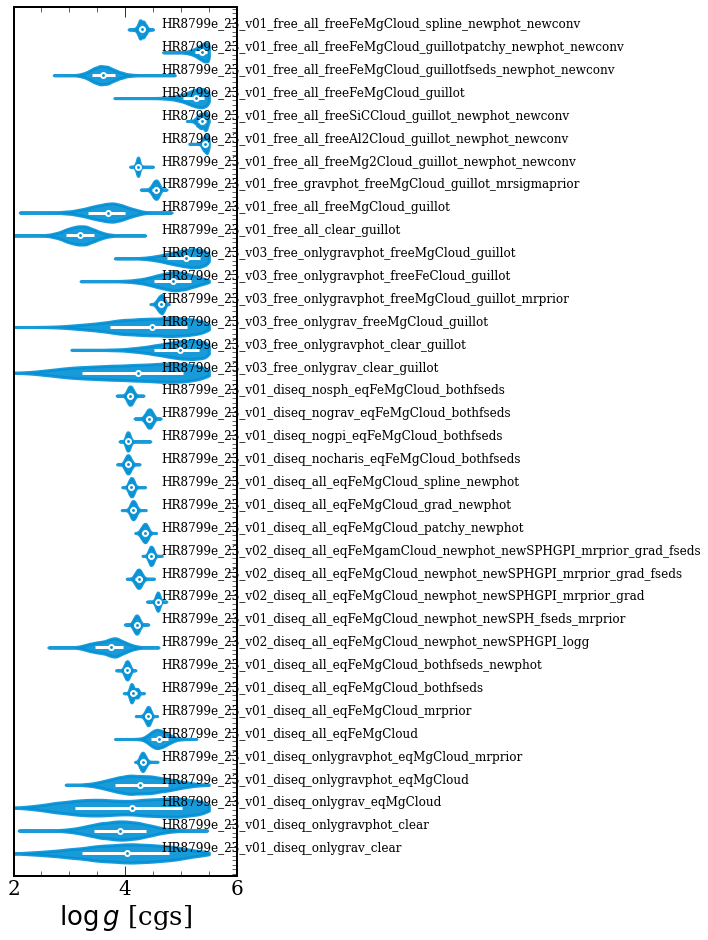

In [187]:
#snames_temp = []
#for i,ret in enumerate(retrievals_d):
#    snames_temp.append(f"Model {i}")
make_violin_plot(samples,
                 retrievals_e, 
                 "log_g", 
                 #labels = snames_temp,
                 planet = "e",
                 normalize = 1.0,
                 vline = 0.0)

In [ ]:
retrievals_b_best = [#'HR8799b_23_v02_diseq_all_scaleos_clear', 
              #'HR8799b_23_v02_diseq_all_scaleos_eqFeCloud', 
              'HR8799b_23_v02_diseq_all_scaleos_eqMgCloud', 
              #'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud', 
              #'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud_mrprior', 
              #'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot',
              #'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_fseds', 
              #'HR8799b_23_v02_diseq_all_scaleos_eqNa2SCloud_mrprior_newdata_newphot', 
              'HR8799b_23_v02_diseq_all_scaleos_freeFeMgCloud_mrprior_newdata_newphot', 
              #'HR8799b_23_v01_free_all_correctos_clear_0nodes_v2', 
              #'HR8799b_23_v01_free_all_correctos_clear_1nodes_v2', 
              #'HR8799b_23_v01_free_all_correctos_clear_2nodes_v2', 
              #'HR8799b_23_v01_free_all_correctos_clear_3nodes_v2', 
              #'HR8799b_23_v01_free_all_correctos_clear_4nodes_v2', 
              #'HR8799b_23_v01_free_all_correctos_clear_5nodes_v2', 
              #'HR8799b_23_v01_free_all_correctos_clear_6nodes_v2', 
              #'HR8799b_23_v01_free_all_correctos_clear_7nodes_v2', 
              ##'HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v4',
              #'HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v4',
              #'HR8799b_23_v01_free_all_correctos_freeMgCloud_2nodes_v4', 
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_3nodes_v4']#, 
              #'HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot' ]
retrievals_c_best = [#'HR8799c_23_v01_diseq_onlygrav_noos_clear', # bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_clear_logg', 
                #'HR8799c_23_v01_diseq_onlygravphot_noos_clear',# bad logg
                #'HR8799c_23_v01_diseq_onlygrav_noos_clear_logg', 
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqFeCloud', # bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqFeCloud', # bad logg
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud_logg',
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_logg', 
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud',# bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud', # bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_mrprior',
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqFeMgCloud', # bad logg
                'HR8799c_23_v01_diseq_all_grav_eqFeMgCloud_logg_fseds_newbins_newphot', 
                'HR8799c_23_v01_diseq_all_noos_eqFeMgCloud_logg', 
                #'HR8799c_23_v01_diseq_nogpi_noos_eqFeMgCloud',# bad logg
                'HR8799c_23_v01_diseq_all_noos_patchyeqFeMgCloud_logg_newbins_newphot', 
                #'HR8799c_23_v01_diseq_all_osbin_patchyeqFeMgCloud_logg_newbins_newphot', 
                #'HR8799c_23_v03_free_all_onlygrav_nogpi_clear_guillot', 
                #'HR8799c_23_v03_free_all_onlygrav_withphot_nogpi_clear_guillot',
                #'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeCloud_guillot', 
                #'HR8799c_23_v03_free_all_onlygrav_nogpi_eqMgCloud_guillot', 
                #'HR8799c_23_v03_free_all_onlygrav_nogpi_freeMgCloud_guillot', 
                #'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeMgCloud_guillot', 
                #'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_all_noos_freeFeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_all_noos_freeMgCloud_guillot']#, 
                #'HR8799c_23_v03_free_nograv_os_freeFeMgCloud_guillot_newphot']
retrievals_d_best = [#'HR8799d_23_v01_diseq_onlygrav_clear', 
                #'HR8799d_23_v01_diseq_onlygravphot_eqFeCloud', 
                #'HR8799d_23_v01_diseq_onlygravphot_eqMgCloud', 
                #'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud_mrprior', 
                #'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud', 
                #'HR8799d_23_v01_diseq_all_eqFeMgCloud_fseds_newconv_newphot',
                'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI', 
                'HR8799d_23_v01_diseq_all_noales_eqFeMgCloud_newconv', 
                'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_spline',
                #'HR8799d_23_v01_diseq_all_nocharis_eqFeMgCloud_newconv_newphot', 
                #'HR8799d_23_v01_diseq_all_nogpi_eqFeMgCloud_newconv', 
                #'HR8799d_23_v01_diseq_all_nograv_eqFeMgCloud_newconv', 
                #'HR8799d_23_v01_diseq_all_nosph_eqFeMgCloud', 
                #'HR8799d_23_v01_diseq_all_nosphfull_eqFeMgCloud', 
                #'HR8799d_23_v01_diseq_all_shortsph_eqFeMgCloud', 
                #'HR8799d_23_v03_free_onlygrav_clear_guillot', 
                #'HR8799d_23_v03_free_onlygravphot_clear_guillot', 
                #'HR8799d_23_v03_free_onlygravphot_clear_free_MgCloud_guillot', 
                #'HR8799d_23_v04_free_onlygravphot_free_MgCloud_guillot',
                #'HR8799d_23_v04_free_all_freeFeMgCloud_guillot', 
                #'HR8799d_23_v04_free_all_eqFeMgCloud_guillot_fseds' 
                #'HR8799d_23_v04_free_all_freeMgFeCloud_spline_scaleALES_newSPHGPI'
                ]
retrievals_e_best = [#'HR8799e_23_v01_diseq_onlygrav_clear',
                #'HR8799e_23_v01_diseq_onlygravphot_clear', 
                #'HR8799e_23_v01_diseq_onlygrav_eqMgCloud', 
                #'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud',
                #'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud_mrprior',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_mrprior', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds_newphot', 
                'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_logg',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_newphot_newSPH_fseds_mrprior', 
                #'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_patchy_newphot', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_grad_newphot',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_spline_newphot', 
                #'HR8799e_23_v01_diseq_nocharis_eqFeMgCloud_bothfseds', 
                #'HR8799e_23_v01_diseq_nogpi_eqFeMgCloud_bothfseds', 
                #'HR8799e_23_v01_diseq_nograv_eqFeMgCloud_bothfseds', 
                #'HR8799e_23_v01_diseq_nosph_eqFeMgCloud_bothfseds', 
                #'HR8799e_23_v03_free_onlygrav_clear_guillot', 
                #'HR8799e_23_v03_free_onlygravphot_clear_guillot', 
                #'HR8799e_23_v03_free_onlygrav_freeMgCloud_guillot', 
                #'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot_mrprior', 
                #'HR8799e_23_v03_free_onlygravphot_freeFeCloud_guillot',
                #'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot',
                #'HR8799e_23_v01_free_all_clear_guillot', 
                'HR8799e_23_v01_free_all_freeMgCloud_guillot',
                #'HR8799e_23_v01_free_gravphot_freeMgCloud_guillot_mrsigmaprior',
                #'HR8799e_23_v01_free_all_freeMg2Cloud_guillot_newphot_newconv', 
                #'HR8799e_23_v01_free_all_freeAl2Cloud_guillot_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeSiCCloud_guillot_newphot_newconv',
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillot', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillotfseds_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_spline_newphot_newconv']


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
abdict = {"H2O_Exomol":np.array([-0.70]),
          "CO_all_iso_HITEMP":np.array([-1.26]),
          "CH4":np.array([-9.0]),
          "CO2":np.array([-1.82]),
          "NH3":np.array([-8.7]),
          "SO2":np.array([-3.28])}
msum = 0
for key, val in abdict.items():
    msum += 10**val[0]
abdict["H2"] = np.log10(np.array([0.766 * (1.0-msum)]))
abdict["He"] = np.log10(np.array([0.234 * (1.0-msum)]))

adf = pd.DataFrame(abdict)
calc_feh_from_abundances(adf, list(abdict.keys()))
print(10**abdict["H2"],adf["Fe/H"].to_numpy(), 10**adf["Fe/H"].to_numpy())

abdict = {"H2O_Exomol":10**np.array([-0.70]),
          "CO_all_iso_HITEMP":10**np.array([-1.26]),
          "CH4":10**np.array([-9.0]),
          "CO2":10**np.array([-1.82]),
          "NH3":10**np.array([-8.7]),
          "SO2":10**np.array([-3.28])}
msum = 0
for key, val in abdict.items():
    msum += val[0]
abdict["H2"] = np.array([0.766 * (1.0-msum)])
abdict["He"] = np.array([0.234 * (1.0-msum)])


(1,) (1,) 18
(1,) (1,) 28.010145
(1,) (1,) 16
(1,) (1,) 44
(1,) (1,) 17
(1,) (1,) 64
(1,) (1,) 2
(1,) (1,) 4
[0.55907219] [1.73517795] [54.34729687]


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
solar_nfracs = {}
solar_nfracs['H'] = 0.9207539305712663
solar_nfracs['He'] = 0.07836886940606574
solar_nfracs['C'] = 0.0002478241000191816
solar_nfracs['N'] = 6.225060569980629e-05
solar_nfracs['O'] = 0.00045096580003490476
solar_nfracs['Na'] = 1.6000869436558967e-06
solar_nfracs['Mg'] = 3.665587420837336e-05
solar_nfracs['Al'] = 2.5950000002008533e-06
solar_nfracs['Si'] = 2.979500000230613e-05
solar_nfracs['P'] = 2.3667020201598627e-07
solar_nfracs['S'] = 1.2137900735543473e-05
solar_nfracs['Cl'] = 2.911679585221254e-07
solar_nfracs['K'] = 9.866056120020401e-08
solar_nfracs['Ca'] = 2.0143901144484638e-06
solar_nfracs['Ti'] = 8.206228044298752e-08
solar_nfracs['V'] = 7.836886941506495e-09
solar_nfracs['Fe'] = 2.911679585221254e-05
solar_nfracs['Ni'] = 1.5280711681810828e-06

metallicity = (n_dict["H2O_Exomol"] + 2*n_dict["CO_all_iso_HITEMP"] + 3*n_dict["CO2"] + 2*n_dict["SO2"] + n_dict["CH4"])/(solar_nfracs['C'] + solar_nfracs['O']+ solar_nfracs['S'])
print(metallicity, np.log10(metallicity))

[67.29406669] [1.82797677]


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
n_dict = mass_to_number(abdict)
print(n_dict)

{'H2O_Exomol': array([0.03302664]), 'CO_all_iso_HITEMP': array([0.0058455]), 'CH4': array([1.86215978e-10]), 'CO2': array([0.00102491]), 'NH3': array([3.49693857e-10]), 'SO2': array([2.44318836e-05]), 'H2': array([0.8328654]), 'He': array([0.12721312])}


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# VALIDATION RETRIEVALS:
#validation = ["Published"]
#Published
#Latest pRT version
#GRAVITY combined
#GRAVITY combined
#baseline v10
#baseline v11
#baseline v12
#baseline v13
#baseline v14
#baseline v 15
#rereduced v8
#rereduced v9 
#rereduced v10
#rereduced v14
#Doelman

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.43

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


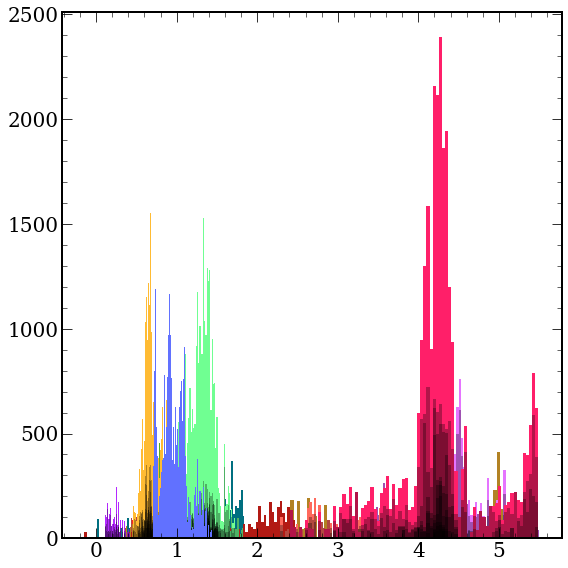

In [ ]:
distributions = {"e":retrievals_e_best,
                 "d":retrievals_d_best,
                 "c":retrievals_c_best,
                 "b":retrievals_b_best}
sample_size = 2000 
num_distr = 0
for val in distributions.values():
    if len(val)>num_distr:
        num_distr = len(val)

fig, ax = plt.subplots(figsize = (8,8))

hist_params = ["Fe/H", "C/O", "R_pl", "log_g"]

data = np.zeros((sample_size, num_distr, len(hist_params),len(planets)))
rands = np.zeros((sample_size, num_distr, len(hist_params),len(planets)))
bin_dict = {}
count_dict = {}
for iplan,planet in enumerate(planets):
    bin_dict[planet] = {}
    count_dict[planet] = {}

    ndist = len(distributions[planet])

    for ipar,param in enumerate(hist_params):
        for idx, distr in enumerate(distributions[planet]):
            norm = 1.0
            if param == "R_pl":
                norm = nc.r_jup_mean
            if param == "mass":
                norm = nc.m_jup
            samples_idx = np.random.randint(low = 0, high = len(distr), size = sample_size, dtype = int)
            rands[:,idx,ipar,iplan] = samples_idx
            data[:,idx,ipar,iplan] = samples[distr].iloc[samples_idx][param]/norm

        #random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
        #sample = data[np.arange(sample_size), random_idx]
        n_par, bins_par, patches_par = ax.hist(data[:,:ndist,ipar,iplan].flatten(), bins=80, density=False)
        bin_dict[planet][param] = bins_par
        count_dict[planet][param] = n_par
        for idx, distr in enumerate(distributions[planet]):
            ax.hist(samples[distr].iloc[rands[:,idx,ipar,iplan]][param], 
                    bins = bin_dict[planet][param], 
                    density = False, 
                    histtype= 'stepfilled', 
                    stacked = False,
                    alpha = 0.3,
                    color = 'k')
#ax.set_yscale('log')


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/nasedkin/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


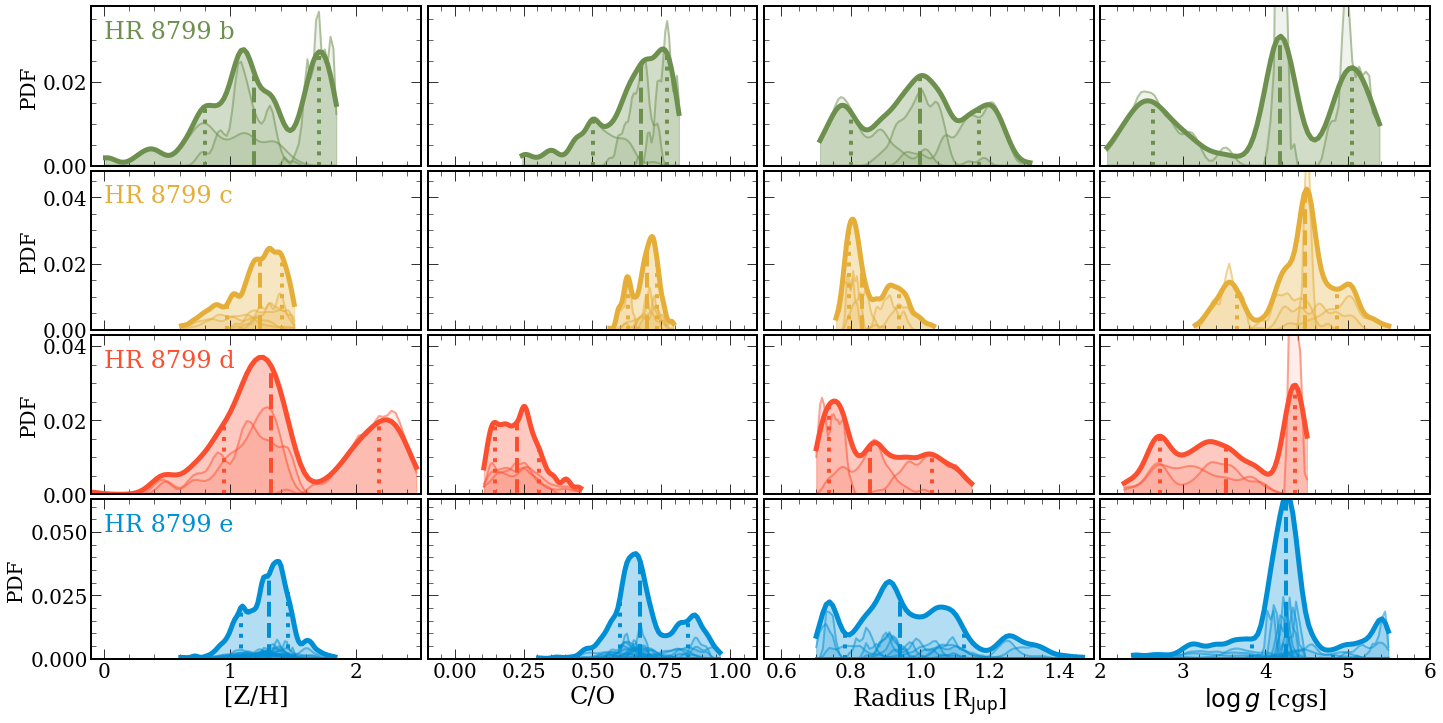

In [ ]:
from scipy import stats
fig, ax = plt.subplots(figsize = (6*len(hist_params),3*len(planets)), 
                       ncols=len(hist_params), 
                       nrows=len(planets),
                       gridspec_kw = {"hspace" : 0.03,"wspace":0.02},
                       sharey=False)

param_borders = {}
param_borders["Fe/H"] = (-0.1,2.51)
param_borders["C/O"] = (-0.1,1.1)
param_borders["R_pl"] = (0.55,1.5)
param_borders["log_g"] = (2,6)

label_dict = {}
label_dict["C/O"] = "C/O"
label_dict["Fe/H"] = "[Z/H]"
label_dict["H2O_Exomol"] = "Water Mass Fraction"
label_dict["CO_all_iso_HITEMP"] = "CO Mass Fraction"
label_dict["CH4"] = "CH4"
label_dict["log_g"] = r"$\log g$ [cgs]"
label_dict["R_pl"] = r"Radius [R$_{\rm Jup}$]"
label_dict["mass"] = r"Mass [M$_{\rm Jup}$]"
label_dict["Teff"] = r"T$_{\rm Eff}$ [K}]"

ylims = [(0.0,0.038),(0.0,0.048),(0.0,0.043),(0.0,0.063)]
planet_labels = ["HR 8799 b", "HR 8799 c", "HR 8799 d" , "HR 8799 e"]
for iplan,planet in enumerate(planets):
    for ipar, param in enumerate(hist_params):
        ndist = len(distributions[planet])
        points = data[:,:ndist,ipar,iplan].flatten()
        kde = stats.gaussian_kde(points)
        kde_eval = kde(bin_dict[planet][param])/np.sum(kde(bin_dict[planet][param]))
        points_sum = np.sum(kde(bin_dict[planet][param]))

        #ax[iplan,ipar].hist(points, bins = bin_dict[planet][param], color = colour_dict[planet], density = False)
        ax[iplan,ipar].plot(bin_dict[planet][param],kde_eval, linewidth = 5, color = colour_dict[planet])
        ax[iplan,ipar].fill_between(bin_dict[planet][param],kde_eval, alpha = 0.3, color = colour_dict[planet])

        q1, m, q3 = np.quantile(points, [0.159, 0.50, 0.841])
        q1idx = (np.abs(bin_dict[planet][param] - q1)).argmin()
        midx = (np.abs(bin_dict[planet][param] - m)).argmin()
        q3idx = (np.abs(bin_dict[planet][param] - q3)).argmin()

        ax[iplan,ipar].vlines(q1,ymin=1e-6,ymax=kde_eval[q1idx], linewidth = 4, linestyle = ':', color = colour_dict[planet])
        ax[iplan,ipar].vlines(m,ymin=1e-6,ymax=kde_eval[midx], linewidth = 4, linestyle = '--', color = colour_dict[planet])
        ax[iplan,ipar].vlines(q3,ymin=1e-6,ymax=kde_eval[q3idx], linewidth = 4, linestyle = ':', color = colour_dict[planet])

        for idx, distr in enumerate(distributions[planet]):
            points_c = data[:,idx,ipar,iplan].flatten()
            if (np.sum(points_c) < 0): continue
            kde_c = stats.gaussian_kde(points_c)
            ax[iplan,ipar].plot(bin_dict[planet][param],
                        kde_c(bin_dict[planet][param])/np.sum(kde_c(bin_dict[planet][param]))/ndist,
                        alpha = 0.5, 
                        linewidth = 2, 
                        color = colour_dict[planet]) 
            ax[iplan,ipar].fill_between(bin_dict[planet][param],
                                kde_c(bin_dict[planet][param])/np.sum(kde_c(bin_dict[planet][param]))/ndist,
                                alpha = 0.1, 
                                color = colour_dict[planet]) 
        #ax[iplan,ipar].set_yscale('log')
        ax[iplan,ipar].set_ylim(ylims[iplan])
        ax[-1,ipar].set_xlabel(label_dict[param], fontsize = 24)
        ax[iplan,ipar].set_xlim(param_borders[param])
        ax[iplan,0].set_ylabel(f"PDF", fontsize = 20)
        if ipar != 0:
            ax[iplan,ipar].set_yticklabels([])
        if iplan != 3:
            ax[iplan,ipar].set_xticklabels([])
    ax[iplan,0].annotate(planet_labels[iplan], 
                        (0,0.8*ax[iplan,0].get_ylim()[1]), 
                        color = colour_dict[planet],
                        fontsize = 24)
plt.savefig(f"plots/HR8799_AllPlanet_AllParams_KDEHists.pdf",bbox_inches = 'tight')

In [ ]:
def write_latex_table(samples, retrievals_use, short_names, parameters_use):
    output_filename = "HR8799_retrieval_summary_table_latex.tex"

    label_dict = {}
    label_dict["C/O"] = "\\textbf{C/O}"
    label_dict["Fe/H"] = "\\textbf{[Z/H]}"
    label_dict["H2O_Exomol"] = "\\textbf{Water Mass Fraction}"
    label_dict["CO_all_iso_HITEMP"] = "\\textbf{CO Mass Fraction}"
    label_dict["CH4"] = "CH4"
    label_dict["log_g"] = "$\\bm{\\log g}$"
    label_dict["R_pl"] = "\\textbf{Radius}"
    label_dict["mass"] = "\\textbf{Mass}"
    label_dict["Teff"] = "$\\mathbf{T_{\\rm Eff}}$"
    label_dict["fsed"] = "$\\mathbf{f_{\\rm SED}}$"
    label_dict["Lbol"] = "$\\bm{\\log L/L_{\\odot}}$"

    unit_dict = {}
    unit_dict["C/O"] = ""
    unit_dict["Fe/H"] = ""
    unit_dict["H2O_Exomol"] = ""
    unit_dict["CO_all_iso_HITEMP"] = ""
    unit_dict["CH4"] = ""
    unit_dict["log_g"] = "[cgs]"
    unit_dict["R_pl"] = "[R$_{\\rm Jup}$]"
    unit_dict["mass"] = "[M$_{\\rm Jup}$]"
    unit_dict["Teff"] = "[K]"
    unit_dict["fsed"] = ""
    unit_dict["Lbol"] = ""
    
    header = "\\textbf{Planet} & \\textbf{Model} & $\\bm{\\Delta\log_{10}}\mathcal{Z}$ & $\\bm{\chi^{2}/\\nu}$ "
    for parameter in parameters_use:
        header += f"& {label_dict[parameter]} "
    units = f" &  &  & "
    for parameter in parameters_use:
        units += f"& {unit_dict[parameter]} "
    count = 0
    with open(output_filename,'w+') as myFile:
        myFile.write("\\toprule\n")
        myFile.write(header)
        myFile.write("\\\\\n")
        myFile.write(units)
        myFile.write("\\\\\n")
        for iplan,planet in enumerate(planets):
            myFile.write("\\midrule\n")
            myFile.write(f"{planet} &")
            for iret, ret in enumerate(retrievals_use[planet]):
                if ret in samples.keys():
                    if iret!=0:
                        myFile.write(f"  &")
                    try:
                        myFile.write(f" {short_names[ret]} &")
                    except KeyError:
                        myFile.write(f" {count} &")
                    try: 
                        myFile.write(f" {samples[ret].log10_baysian_evidence - max_evidence[planet]} &")
                    except:
                        myFile.write(f" \\ldots &")
                    try:
                        myFile.write(f" {samples[ret].chi2_DoF} &")
                    except:
                        myFile.write(f" \\ldots &")
                        
                    for ipar,param in enumerate(parameters_use):
                        end = " & "
                        if ipar == (len(parameters_use)-1):
                            end = " \\\\[2pt]\n"
                        if param == "Profile":
                            try:
                                myFile.write(f" {samples[ret].temperature_profile} {end}")
                            except:
                                myFile.write(f" \\ldots {end}")
                        
                        if param in samples[ret].columns:
                            med = np.quantile(samples[ret][param], q = 0.50)
                            low = med - np.quantile(samples[ret][param], q = 0.159)
                            high = np.quantile(samples[ret][param], q = 0.841)-med
                            if param == 'R_pl':
                                med/=nc.r_jup_mean
                                low/=nc.r_jup_mean
                                high/=nc.r_jup_mean
                            if param == 'mass':
                                med/=nc.m_jup
                                low/=nc.m_jup
                                high/=nc.m_jup
                            if med - low < samples[ret][param].min():
                                myFile.write(f"$>{med:.2g}")
                            elif med + high < samples[ret][param].max():
                                myFile.write(f"$<{med:.2g}")
                            else:
                                myFile.write(f"${med:.2g}_{{-{low:.1g}}}^{{+{high:.1g}}}${end}")
                        else: 
                            myFile.write(f"\\ldots{end}")
                    count += 1
        myFile.write("\\bottomrule\n")

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:30: DeprecationWarning: invalid escape sequence \l
<>:30: DeprecationWarning: invalid escape sequence \l
<>:30: DeprecationWarning: invalid escape sequence \l
<ipython-input-56-633959a053bc>:30: DeprecationWarning: invalid escape sequence \l
  header = "\\textbf{Planet} & \\textbf{Model} & $\\bm{\\Delta\log_{10}}\mathcal{Z}$ & $\\bm{{\chi^{{2}}/\\nu}}$ "


In [ ]:
parameters_use = ["Teff", "log_g", "Fe/H", "C/O", "R_pl", "Lbol", "mass"]
distributions = {"b":retrievals_b,
                 "c":retrievals_c,
                 "d":retrievals_d,
                 "e":retrievals_e}
write_latex_table(samples, distributions, {}, parameters_use)


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [188]:
parameters_use_long =  ["R_pl", 
                        "mass",
                        "log_g", 
                        "Profile",
                        "Fe/H",
                        "C/O", 
                        "log_pquench", 
                        "H2O_Exomol", 
                        "CO_all_iso_HITEMP",
                        "sigma_lnorm",
                        "b_hans",
                        "log_kzz",
                        "fsed",
                        "fsed_MgSiO3(c)",
                        "fsed_Fe(c)",
                        "log_X_cb_MgSiO3(c)",
                        "log_X_cb_Fe(c)",
                        "log_Pbase_MgSiO3(c)",
                        "log_PBase_Fe(c)"
                        ]



/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5749.8, 1.83
5748.4, 1.82